# RDS Homework 2 Template
## Spring 2024


In [2]:
!pip install shap

In [3]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")



[nltk_data] Downloading package punkt to /Users/lmx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Problem 3

### Part (A)

In [4]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

In [5]:
# Initialize & fit tf-idf vectorizer
vectorizer = TfidfVectorizer()
train = vectorizer.fit_transform(newsgroups_train.data)
test = vectorizer.transform(newsgroups_test.data)


In [6]:
# Train a SGDClassifier
clf = SGDClassifier(loss='log_loss')
clf.fit(train, newsgroups_train.target)

SGDClassifier(loss='log_loss')

### Part (B)

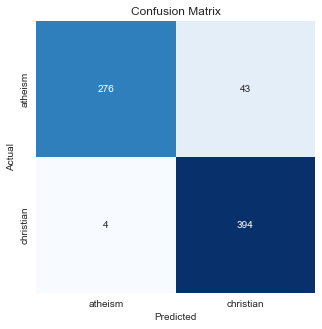

In [7]:
# Confusion Matrix
pred = clf.predict(test)
cm = sklearn.metrics.confusion_matrix(newsgroups_test.target, pred)
# Show confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Explainer

In [8]:
# Initialize the linear explainer and apply to test data
explainer = shap.LinearExplainer(clf, train, feature_pertubation="interventional")
shap_values = explainer.shap_values(test)


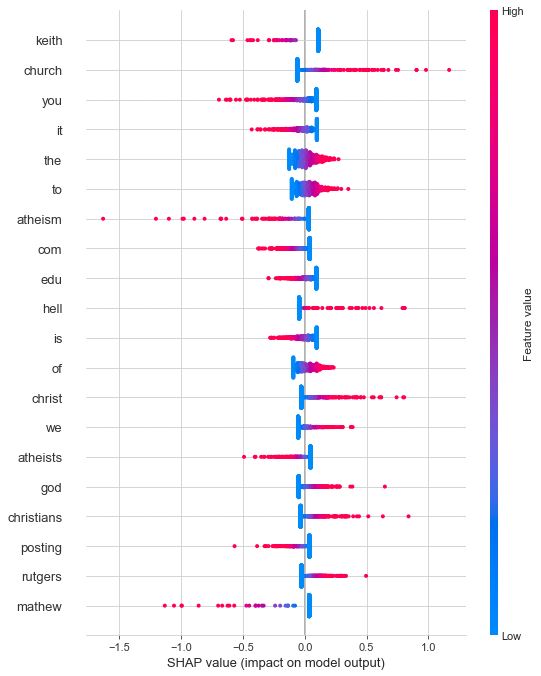

In [9]:
# Select 5 documents in the test set for explanation
X_test_array = test.toarray()
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names_out())

In [10]:
# Visually explain 5 documents selected from the test set
shap.initjs()
correctly_classified = np.where(pred == newsgroups_test.target)[0]
misclassified = np.where(pred != newsgroups_test.target)[0]
correctly_classified = np.random.choice(correctly_classified, 3)
misclassified = np.random.choice(misclassified, 2)
selected_docs = np.concatenate([correctly_classified, misclassified])
#for doc_id in selected_docs:
    #print(f"Document ID: {doc_id}")
    #print(f"Predicted class: {class_names[pred[doc_id]]}")
    #print(f"Actual class: {class_names[newsgroups_test.target[doc_id]]}")
    #print("Atheism" if newsgroups_test.target[doc_id] else "Negative", "Review:")
    #print(newsgroups_test[doc_id])
shap.force_plot(explainer.expected_value, shap_values[selected_docs[0],:], X_test_array[selected_docs[0],:],feature_names=vectorizer.get_feature_names_out())
plt.show()

### Part (C)


#### Part (i)

In [104]:
# Compute the accuracy of the classifier and the number of misclassified documents
accuracy_base = np.mean(pred == newsgroups_test.target)
print("Accuracy: {}".format(accuracy))
print("Number of misclassified documents: {}".format(np.sum(pred != newsgroups_test.target)))

Accuracy: 0.9344490934449093
Number of misclassified documents: 47


#### Part (ii)

In [105]:
# Calculate conf_i for all misclassified documents
probabilities = clf.predict_proba(test)
conf = np.abs(probabilities[:, 0] - probabilities[:, 1])
misclassified_indices = np.where(pred != newsgroups_test.target)[0]
conf_misclassified = conf[misclassified_indices]
conf_misclassified

array([3.69166197e-03, 3.77171646e-01, 9.12145033e-01, 1.52023250e-01,
       7.13992785e-01, 1.40573089e-01, 9.85596988e-02, 1.18069277e-01,
       3.79417877e-01, 2.32609983e-01, 5.42353779e-01, 4.22053399e-01,
       2.06849667e-01, 2.57114290e-01, 1.86097886e-01, 4.71353326e-01,
       9.75340128e-02, 1.09360084e-01, 1.28049837e-01, 2.01496848e-01,
       5.25625838e-01, 3.52182731e-01, 3.24942142e-01, 7.56631506e-04,
       3.60191756e-01, 1.57737971e-01, 4.80319670e-01, 1.57271247e-01,
       2.96111846e-03, 3.65487801e-01, 3.96589488e-01, 2.67168940e-01,
       1.80302469e-01, 1.73869854e-01, 9.09098587e-01, 1.20312517e-01,
       7.77398246e-01, 7.76858356e-01, 6.68139672e-01, 1.16952387e-01,
       5.15169799e-01, 3.82254987e-02, 3.21773714e-01, 4.36872915e-01,
       3.82210975e-01, 4.66845548e-01, 1.99388675e-01])

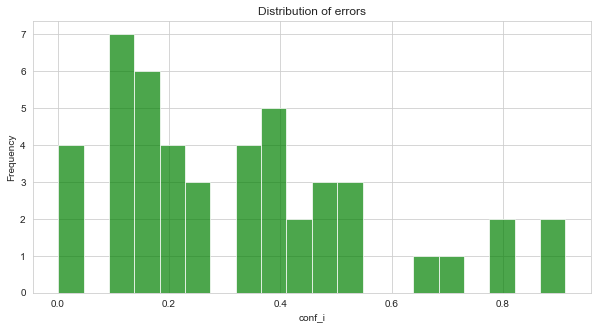

In [106]:
# Plot conf_i
plt.figure(figsize=(10,5))
plt.hist(conf_misclassified, bins=20, color='green', alpha=0.7)
plt.xlabel('conf_i')
plt.ylabel('Frequency')
plt.title('Distribution of errors')
plt.show()

#### Part (iii)

In [107]:
# Identify tokens (word_j) that contributed to the misclassification of documents

count_dict = defaultdict(int)
weight_dict = defaultdict(float)

for i in misclassified_indices:
    shap_values_i = shap_values[i]
    actual_class = newsgroups_test.target[i]
    
    for j in range(len(shap_values_i)):
        if (actual_class == 0 and shap_values_i[j] > 0) or (actual_class == 1 and shap_values_i[j] < 0):
            count_dict[j] += 1
            weight_dict[j] += np.abs(shap_values_i[j])


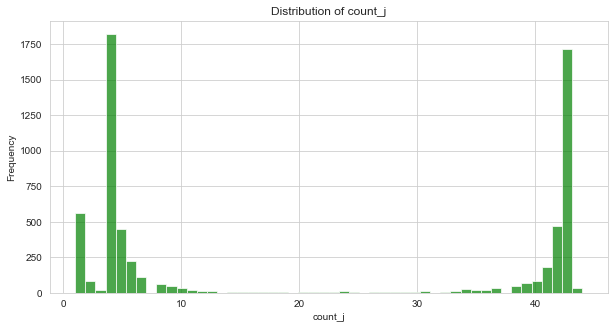

In [108]:
# Plot the distribution of count_j
plt.figure(figsize=(10,5))
plt.hist(count_dict.values(), bins=50, color='green', alpha=0.7)
plt.xlabel('count_j')
plt.ylabel('Frequency')
plt.title('Distribution of count_j')
plt.show()

In [109]:
# get the top 10 tokens that contributed to the misclassification
top_10 = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)[:10]
for idx, count in top_10:
    print(f"Token: {vectorizer.get_feature_names_out()[idx]}")
    print(f"Count: {count}")
    print("\n")

Token: alink
Count: 44


Token: alternatives
Count: 44


Token: applies
Count: 44


Token: apply
Count: 44


Token: aren
Count: 44


Token: assertions
Count: 44


Token: bureau
Count: 44


Token: charley
Count: 44


Token: cheers
Count: 44


Token: closed
Count: 44




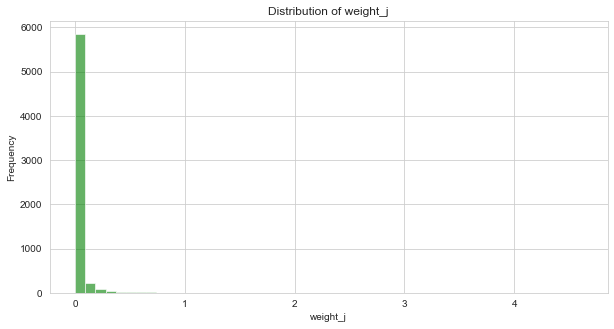

In [110]:
# Plot the distribution of weight_j
plt.figure(figsize=(10,5))
plt.hist(weight_dict.values(), bins=50, color='green', alpha=0.6)
plt.xlabel('weight_j')
plt.ylabel('Frequency')
plt.title('Distribution of weight_j')
plt.show()

In [111]:
# Identify the top 10 tokens that contributed to the misclassification of documents

top_10_tokens = sorted(weight_dict.items(), key=lambda x: x[1], reverse=True)[:100]
top_10_tokens = [(vectorizer.get_feature_names_out()[i], count_dict[i], weight) for i, weight in top_10_tokens]
top_10_tokens

[('keith', 43, 4.62047357883822),
 ('of', 29, 2.5026240895813476),
 ('christian', 23, 2.381446208961387),
 ('the', 28, 2.343743798441077),
 ('church', 13, 2.2392348206665953),
 ('to', 28, 2.0320448879580932),
 ('caltech', 43, 2.001558653055799),
 ('and', 25, 1.975421240554239),
 ('you', 26, 1.9680421696934043),
 ('faith', 14, 1.912761685737652),
 ('christ', 16, 1.8911490664459232),
 ('atheists', 36, 1.8493636763474728),
 ('edu', 33, 1.7825213170837475),
 ('it', 26, 1.7583986586409857),
 ('sandvik', 43, 1.7158564027391825),
 ('jesus', 18, 1.6817971899896733),
 ('mathew', 42, 1.4764790065851157),
 ('god', 19, 1.4155086535164008),
 ('is', 24, 1.3511820900171578),
 ('com', 33, 1.2741692751709355),
 ('mangoe', 44, 1.2420370993434524),
 ('temple', 9, 1.2114750765072562),
 ('atheism', 37, 1.210369054888676),
 ('we', 21, 1.176255059899255),
 ('morality', 35, 1.130665752628758),
 ('love', 12, 1.1272273530797843),
 ('christians', 13, 1.1246372370950075),
 ('posting', 30, 1.1101570369487719),
 ('

### Part (D)

In [112]:
# Get the count_j and weight_j for correctly classified documents
count_dict_correct = defaultdict(int)
weight_dict_correct = defaultdict(float)

for i in correctly_classified:
    shap_values_i = shap_values[i]
    actual_class = newsgroups_test.target[i]
    
    for j in range(len(shap_values_i)):
        if (actual_class == 0 and shap_values_i[j] < 0) or (actual_class == 1 and shap_values_i[j] > 0):
            count_dict_correct[j] += 1
            weight_dict_correct[j] += np.abs(shap_values_i[j])

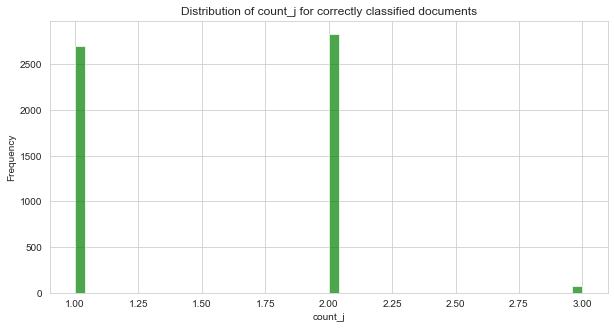

In [113]:
# Plot the distribution of count_j for correctly classified documents
plt.figure(figsize=(10,5))
plt.hist(count_dict_correct.values(), bins=50, color='green', alpha=0.7)
plt.xlabel('count_j')
plt.ylabel('Frequency')
plt.title('Distribution of count_j for correctly classified documents')
plt.show()

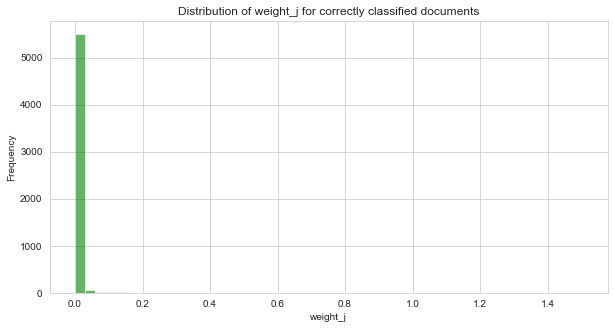

In [114]:
# Plot the distribution of weight_j for correctly classified documents
plt.figure(figsize=(10,5))
plt.hist(weight_dict_correct.values(), bins=50, color='green', alpha=0.6)
plt.xlabel('weight_j')
plt.ylabel('Frequency')
plt.title('Distribution of weight_j for correctly classified documents')
plt.show()

In [131]:
# Implement a strategy for feature selection
# Remove features that: have low weight in both classes and have have high count
# Or have hight weight in misclassified documents
# Get low weight and high count tokens as features

low_weight_threshold = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
high_weight_threshold = 1
count_threshold = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
remove_hh = True
best_low_weight_threshold = 0
best_count_threshold = 0
best_accuracy = 0
accuracies = []
for i in low_weight_threshold:
    for j in count_threshold:
        print(f"Weight threshold: {i}")
        print(f"Count threshold: {j}")
        # Round 1 - low weight, high count | high weight
        torm_features = [vectorizer.get_feature_names_out()[k] for k, count in count_dict.items() if (count >= j and weight_dict[k] <= i) or (weight_dict[k] >= high_weight_threshold)]

        # Round 2 - low weight, high count | high weight (optional) in correctly classified documents
        if remove_hh:
            # If true we also remove features with high weight in correctly classified documents
            pos_features = [vectorizer.get_feature_names_out()[k] for k, count in count_dict_correct.items() if (weight_dict_correct[k] <= i and count >= j) or (weight_dict_correct[i] >= high_weight_threshold)]
        else:
            pos_features = [vectorizer.get_feature_names_out()[k] for k, count in count_dict_correct.items() if weight_dict_correct[k] <= i and count >= j]
        torm_features = list(set(torm_features + pos_features))
        print(f"Number of features to remove: {len(torm_features)}")
        vectorizer_fs = TfidfVectorizer(stop_words=torm_features)
        train_fs = vectorizer_fs.fit_transform(newsgroups_train.data)
        test_fs = vectorizer_fs.transform(newsgroups_test.data)
        clf_fs = SGDClassifier(loss='log_loss')
        clf_fs.fit(train_fs, newsgroups_train.target)
        pred_fs = clf_fs.predict(test_fs)
        accuracy = np.mean(pred_fs == newsgroups_test.target)
        accuracies.append(accuracy)
        print(f"Accuracy after feature selection: {accuracy}")
        print(f"Accuracy improvement: {accuracy - accuracy_base}")
        best_accuracy = max(best_accuracy, accuracy)
        if best_accuracy == accuracy:
            best_low_weight_threshold = i
            best_count_threshold = j
        print("\n")
        print("\n")


Weight threshold: 0.01
Count threshold: 1
Number of features to remove: 5935
Accuracy after feature selection: 0.9344490934449093
Accuracy improvement: 0.0




Weight threshold: 0.01
Count threshold: 2
Number of features to remove: 4573
Accuracy after feature selection: 0.9358437935843794
Accuracy improvement: 0.001394700139470073




Weight threshold: 0.01
Count threshold: 3
Number of features to remove: 3983
Accuracy after feature selection: 0.9288702928870293
Accuracy improvement: -0.00557880055788007




Weight threshold: 0.01
Count threshold: 4
Number of features to remove: 3968
Accuracy after feature selection: 0.9358437935843794
Accuracy improvement: 0.001394700139470073




Weight threshold: 0.01
Count threshold: 5
Number of features to remove: 2189
Accuracy after feature selection: 0.9400278940027894
Accuracy improvement: 0.00557880055788007




Weight threshold: 0.01
Count threshold: 6
Number of features to remove: 1911
Accuracy after feature selection: 0.9442119944211994
Acc

Best accuracy: 0.9483960948396095
Best low weight threshold: 0.02
Best count threshold: 2


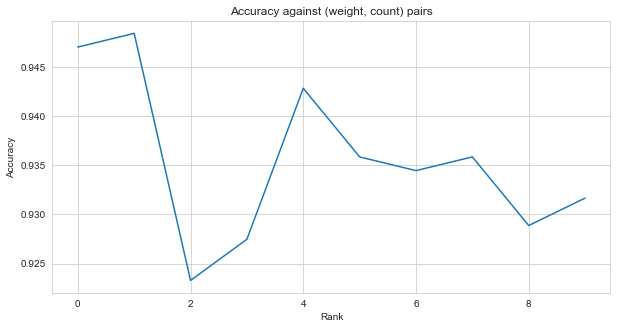

In [126]:
# Plot accuracy against (weight, count) pairs by ranking
print("Best accuracy: {}".format(best_accuracy))
print("Best low weight threshold: {}".format(best_low_weight_threshold))
print("Best count threshold: {}".format(best_count_threshold))

plt.figure(figsize=(10,5))
plt.plot(accuracies)
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.title('Accuracy against (weight, count) pairs')
plt.show()


Best accuracy: 0.9456066945606695
Best low weight threshold: 0.02
Best count threshold: 2


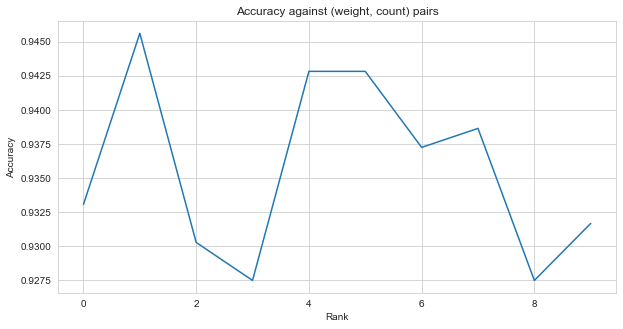

In [130]:


# Remove high-weight features in correctly classified documents
print("Best accuracy: {}".format(best_accuracy))
print("Best low weight threshold: {}".format(best_low_weight_threshold))
print("Best count threshold: {}".format(best_count_threshold))

plt.figure(figsize=(10,5))
plt.plot(accuracies)
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.title('Accuracy against (weight, count) pairs')
plt.show()


Best accuracy: 0.9497907949790795
Best low weight threshold: 0.02
Best count threshold: 6


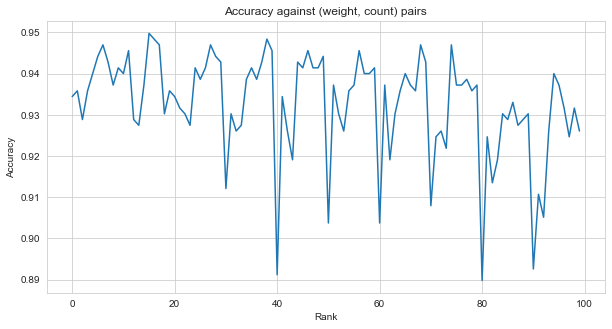

In [132]:
print("Best accuracy: {}".format(best_accuracy))
print("Best low weight threshold: {}".format(best_low_weight_threshold))
print("Best count threshold: {}".format(best_count_threshold))

plt.figure(figsize=(10,5))
plt.plot(accuracies)
plt.xlabel('Rank')
plt.ylabel('Accuracy')
plt.title('Accuracy against (weight, count) pairs')
plt.show()

In [ ]:
# Identify at least one example that was misclassified before feature selection and that is classified correctly after feature selection
print("Let's see")
